# Explore the Vital Dynamics Births Components

In [1]:
from pathlib import Path

import numpy as np

from laser.core.utils import grid
from laser.core import PropertySet
from laser.generic.newutils import ValuesMap
from laser.generic import Model
from laser.generic import SEIR
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.generic.vitaldynamics import BirthsByCBR

from laser.core import __version__ as laser_core_version
from laser.generic import __version__ as laser_generic_version
print(f"LASER version: {laser_core_version}")
print(f"LASER Generic version: {laser_generic_version}")


LASER version: 0.8.0
LASER Generic version: 0.0.0


In [2]:
ROWS = 1
COLS = 1
NNODES = ROWS * COLS
NTICKS = 3650
CBR = 20.0  # Crude Birth Rate 20.0 per 1000 per year

scenario = grid(M=ROWS, N=COLS)
scenario["S"] = scenario.population
scenario["E"] = scenario["I"] = scenario["R"] = 0
parameters = PropertySet({"nticks": NTICKS})
birthrates = ValuesMap.from_scalar(CBR, NNODES, NTICKS)

expdurdist = dists.normal(loc=5.0, scale=1.0)
infdurdist = dists.normal(loc=7.0, scale=2.0)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Population WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx
age_data = np.loadtxt(Path.cwd() / "data" / "Nigeria-Distribution-2020.csv", delimiter=",", usecols=0)[0:89]  # Up to age 89 (largest value int16 can hold.)
pyramid = AliasedDistribution(age_data)


In [3]:
model = Model(scenario, parameters, birthrates=birthrates)

model.components = [
    SEIR.Susceptible(model),
    SEIR.Exposed(model, expdurdist, infdurdist),
    SEIR.Infectious(model, infdurdist),
    SEIR.Recovered(model),
    BirthsByCBR(model, birthrates, pyramid),
]

pop_start = model.people.count
print(f"At t=0    {pop_start =:,}")
model.run()
pop_finish = model.people.count
print(f"At t={model.params.nticks} {pop_finish=:,}")


At t=0    pop_start =74,979


74,979 agents in 1 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 2419.74it/s]

At t=3650 pop_finish=91,534


Let's check births over the simulation.

In [4]:
growth = (1.0 + CBR / 1000.0) ** (NTICKS / 365.0)
expected_pop = int(pop_start * growth)
print(f"Expected population: {expected_pop:,}")
print(f"Actual population:   {pop_finish:,}")
print(f"Difference:          {pop_finish - expected_pop:,} ({(pop_finish - expected_pop) / expected_pop * 100:.2f}%)")

Expected population: 91,398
Actual population:   91,534
Difference:          136 (0.15%)


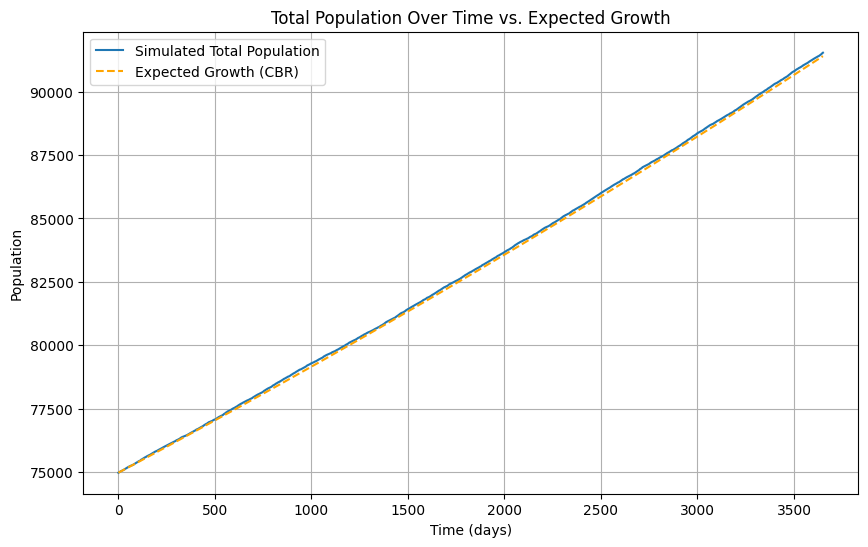

In [5]:
# "Please plot the total population, model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R, over time with the expected growth based on pop_start and the CBR overlaid."

import matplotlib.pyplot as plt

# Calculate total population over time
total_population = model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R

# Calculate expected population growth curve
time = np.arange(NTICKS + 1)
expected_curve = pop_start * (1.0 + CBR / 1000.0) ** (time / 365.0)

plt.figure(figsize=(10, 6))
plt.plot(time, total_population, label="Simulated Total Population")
plt.plot(time, expected_curve, '--', label="Expected Growth (CBR)", color='orange')
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Total Population Over Time vs. Expected Growth")
plt.legend()
plt.grid(True)
plt.show()

## Spatially-varying CBR

Let's try a 2 node simulation with a high CBR rural node and lower CBR urban node.

In [6]:
# Set up a 2-node scenario with 100_000 people in the rural node and 500_000 people in the urban node.
scenario = grid(M=1, N=2)
scenario.population = [100_000, 500_000]
scenario["S"] = scenario.population
scenario["E"] = scenario["I"] = scenario["R"] = 0
parameters = PropertySet({"nticks": NTICKS})
rural_cbr = 30.0  # CBR = 30 per 1000 per year in rural
urban_cbr = 15.0  # CBR = 15 per 1000 per year in urban
birthrates = ValuesMap.from_nodes(np.array([rural_cbr, urban_cbr]), NTICKS)

spatial = Model(scenario, parameters, birthrates=birthrates)

spatial.components = [
    SEIR.Susceptible(spatial),
    SEIR.Exposed(spatial, expdurdist, infdurdist),
    SEIR.Infectious(spatial, infdurdist),
    SEIR.Recovered(spatial),
    BirthsByCBR(spatial, birthrates, pyramid),
]

pop_start = spatial.people.count
print(f"At t=0    {pop_start  =:8,}")
spatial.run()
pop_finish = spatial.people.count
print(f"At t={spatial.params.nticks} {pop_finish =:8,}")

print()

total_pop = spatial.nodes.S + spatial.nodes.E + spatial.nodes.I + spatial.nodes.R
for node_idx, cbr in enumerate([rural_cbr, urban_cbr]):
    growth = (1.0 + cbr / 1000.0) ** (NTICKS / 365.0)
    expected_pop = int(total_pop[0,node_idx] * growth)
    actual_pop = total_pop[-1,node_idx]
    print(f"Node {node_idx} (CBR={cbr}):")
    print(f"  Expected population: {expected_pop:,}")
    print(f"  Actual population:   {actual_pop:,}")
    print(f"  Difference:          {actual_pop - expected_pop:,} ({(actual_pop - expected_pop) / expected_pop * 100:.2f}%)")

At t=0    pop_start  = 600,000


600,000 agents in 2 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 2979.18it/s]

At t=3650 pop_finish = 714,291

Node 0 (CBR=30.0):
  Expected population: 134,391
  Actual population:   134,092
  Difference:          -299 (-0.22%)
Node 1 (CBR=15.0):
  Expected population: 580,270
  Actual population:   580,199
  Difference:          -71 (-0.01%)


## Temporally-varying CBR

Let's set up a single node scenario with decreasing CBR over time.

At t=0    pop_start  = 100,000


100,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 3431.92it/s]

At t=3650 pop_finish = 121,970

Expected population: 121,879
Actual population:   121,970
Difference:          91 (0.07%)


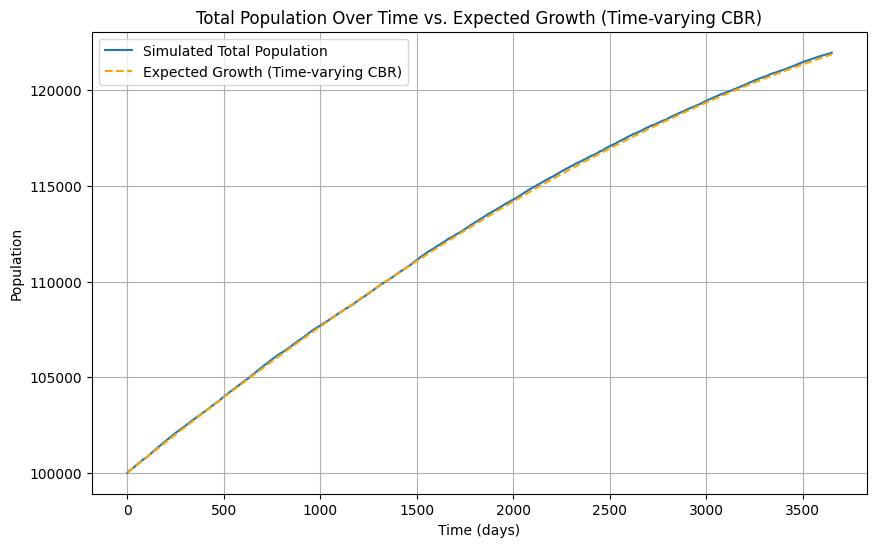

In [7]:
# Set up a single-node scenario with decreasing CBR over time.
scenario = grid(M=1, N=1, population_fn=lambda r, c: 100_000)
scenario["S"] = scenario.population
scenario["E"] = scenario["I"] = scenario["R"] = 0
parameters = PropertySet({"nticks": NTICKS})
time_varying_cbr = np.linspace(30.0, 10.0, NTICKS)  # CBR decreases from 30 to 10 per 1000 per year
birthrates = ValuesMap.from_timeseries(time_varying_cbr, 1)
temporal = Model(scenario, parameters, birthrates=birthrates)
temporal.components = [
    SEIR.Susceptible(temporal),
    SEIR.Exposed(temporal, expdurdist, infdurdist),
    SEIR.Infectious(temporal, infdurdist),
    SEIR.Recovered(temporal),
    BirthsByCBR(temporal, birthrates, pyramid),
]
pop_start = temporal.people.count
print(f"At t=0    {pop_start  =:8,}")
temporal.run()
pop_finish = temporal.people.count
print(f"At t={temporal.params.nticks} {pop_finish =:8,}")

print()

# Calculate expected population with time-varying CBR
total_pop = temporal.nodes.S + temporal.nodes.E + temporal.nodes.I + temporal.nodes.R
expected_pop = pop_start
for cbr in time_varying_cbr:
    growth = (1.0 + cbr / 1000.0) ** (1.0 / 365.0)
    expected_pop *= growth
expected_pop = int(expected_pop)
print(f"Expected population: {expected_pop:,}")
print(f"Actual population:   {pop_finish:,}")
print(f"Difference:          {pop_finish - expected_pop:,} ({(pop_finish - expected_pop) / expected_pop * 100:.2f}%)")

# Let's plot the total population over time with the expected growth based on time-varying CBR overlaid.
import matplotlib.pyplot as plt

# Calculate total population over time
total_population = temporal.nodes.S + temporal.nodes.E + temporal.nodes.I + temporal.nodes.R

# Calculate expected population growth curve with time-varying CBR
time = np.arange(NTICKS + 1)
expected_curve = np.zeros(NTICKS + 1)
expected_curve[0] = pop_start
for t in range(1, NTICKS + 1):
    cbr = time_varying_cbr[t - 1]
    growth = (1.0 + cbr / 1000.0) ** (1.0 / 365.0)
    expected_curve[t] = expected_curve[t - 1] * growth

plt.figure(figsize=(10, 6))
plt.plot(time, total_population, label="Simulated Total Population")
plt.plot(time, expected_curve, '--', label="Expected Growth (Time-varying CBR)", color='orange')
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Total Population Over Time vs. Expected Growth (Time-varying CBR)")
plt.legend()
plt.grid(True)
plt.show()
